# import

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.nn.utils.rnn import pad_sequence
import numpy as np

from transformers import BertModel
from transformers import BertTokenizer
import torch.nn as nn
import time

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# to data loader

In [17]:
class dataset(Dataset):
    def __init__(self, path, tokenizer, balancing=False):
        self.tokenizer = tokenizer
        self.balancing = balancing
        self.name = path
        self.read_csv(path)
     

    def __getitem__(self, idx):
        label, text = self.df.iloc[idx, :3].values
        
        label_tensor = torch.tensor(label)

        word_pieces = ["[cls]"]
        tokens = self.tokenizer.tokenize(text)
        if len(tokens) > 500:
            tokens = tokens[:200] + tokens[-300:]
        word_pieces += tokens
        len_word_pieces = len(word_pieces)
        
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
            
        return tokens_tensor, label_tensor
    
    def __len__(self):
        return len(self.df)

    def read_csv(self, path):
        self.df = pd.read_csv(path)

        if self.balancing == True:
            g = self.df.groupby('truth')
            self.df = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))

        # five to three classes
        self.df['truth'] = np.where(self.df['truth'].values == 0, 0, self.df['truth'])
        self.df['truth'] = np.where(self.df['truth'].values == 1, 0, self.df['truth'])
        self.df['truth'] = np.where(self.df['truth'].values == 2, 1, self.df['truth'])
        self.df['truth'] = np.where(self.df['truth'].values == 3, 2, self.df['truth'])
        self.df['truth'] = np.where(self.df['truth'].values == 4, 2, self.df['truth'])

        print("Size :",len(self.df))
        # self.draw_df_label()

    def get_df(self):
        return self.df

    def get_len(self):
        return len(self.df)

    def draw_df_label(self):
        ax = self.df['truth'].value_counts(sort=False).plot(kind="barh")
        ax.set_xlabel(self.name)
        ax.set_ylabel("Label")
    

In [18]:
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)

    label_ids = torch.stack([s[1] for s in samples])
    
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, masks_tensors, label_ids

In [19]:
tokenizer =BertTokenizer.from_pretrained('bert-base-cased')

Size : 2352
Size : 5487


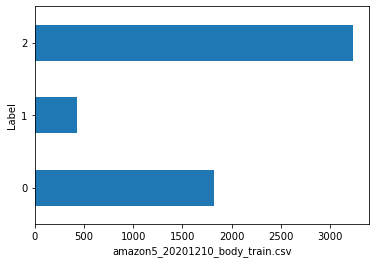

In [20]:
amazon_20201210_test_set = dataset(path="amazon5_20201210_body_test.csv", tokenizer=tokenizer, balancing=False)
amazon_20201210_train_set = dataset(path="amazon5_20201210_body_train.csv", tokenizer=tokenizer, balancing=False)
amazon_20201210_train_set.draw_df_label()

Size : 2210
Size : 8544


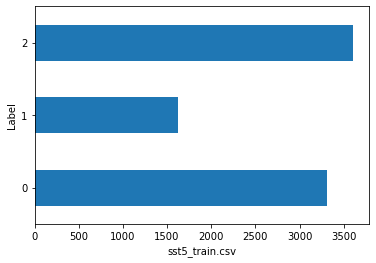

In [21]:
sst5_test_set = dataset(path='sst5_test.csv', tokenizer=tokenizer, balancing=False)
sst5_train_set = dataset(path='sst5_train.csv', tokenizer=tokenizer, balancing=False)
sst5_train_set.draw_df_label()

Size : 10100


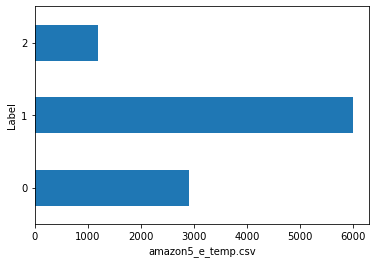

In [22]:
balance_set = dataset(path='amazon5_e_temp.csv', tokenizer=tokenizer, balancing=False)
balance_set.draw_df_label()

In [8]:
train_set = ConcatDataset([amazon_20201210_train_set, sst5_train_set, balance_set])
print(len(train_set))
dic={}
for i,j in train_set:
    idx = int(j)
    if idx in dic:
        dic[idx] += 1
    else:
        dic[idx] = 0
print(dic)

24131
{2: 8044, 1: 8051, 0: 8033}


In [9]:
for i,j in train_set:
    print(i.size(), j)
    tokens = tokenizer.convert_ids_to_tokens(i.tolist())
    combined_text = " ".join(tokens)
    print(combined_text)
    break

torch.Size([307]) tensor(2)
[UNK] I purchased this and set it up for my friend ' s granddaughter . I ' m also a PC building en ##thus ##ias ##t that does IT work for a living . Right out of the box this thing impressed me . Very re ##sp ##ons ##ive and the right balance of hardware to perform really well for more than just average use . I ' m really happy to see that it also includes USB Type C for connectivity . Just a heads - up before buying this though . It does not have old style USB Type A connections on it . You will need an adapt ##er , hub , or just buy new peripheral ##s with a USB Type C connector . For me it ' s not a big deal , because I already have upgraded most of my personal gear . For those un ##sus ##pect ##ing buyers it may be a small annoyance when you first start to use it . Especially if you have a USB mouse that you plan on using . With the Blue ##tooth connectivity I simply paired my mouse and it works great . The same can obviously be done with other Blue ##to

# bert Classifier

In [23]:
class bert_classifier(nn.Module):
    def __init__(self, num_class=5, pretrain_model="bert-base-uncased"):
        super(bert_classifier, self).__init__()
        self.pretrain_model = pretrain_model
        self.num_class = num_class

        self.bert = BertModel.from_pretrained(pretrain_model)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, num_class)

    def forward(self, input_ids, attention_mask=None):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        drop_output = self.drop(pooled_output)
        linear_output = self.out(drop_output)
        return linear_output

    def get_num_class(self):
        return self.num_class

    def get_pretrain_model_name(self):
        return self.pretrain_model

In [24]:
class sentiment_analysis():
    def __init__(self, model, loss_fn, lr):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer =torch.optim.Adam(model.parameters(), lr=lr)
        
        self.name = model.get_pretrain_model_name()
        self.num_labels = model.get_num_class()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def train(self, loader, epochs):
        all_data = len(loader)
        for epoch in range(epochs):
            finish_data = 0
            losses = []
            current_times = []
            correct_predictions = 0
            
            for data in loader:
                t0 = time.time()
                tokens_tensors, masks_tensors, labels = [t.to(self.device) for t in data]
   
                outputs = self.model(input_ids=tokens_tensors,  attention_mask=masks_tensors)
                loss = self.loss_fn(outputs, labels.type(torch.LongTensor).to(self.device))
                losses.append(loss.item())
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                finish_data += 1
                current_times.append(round(time.time()-t0,3))
                current = np.mean(current_times)
                hr, min, sec = self.evl_time(current*(all_data-finish_data) + current*all_data*(epochs-epoch-1) + current/2*all_data*(epochs-epoch-1))
                print('epoch:', epoch, " batch:", finish_data, "/" , all_data, " loss:", np.mean(losses), " hr:", hr, " min:", min," sec:", sec)         

            self.save_model("train-epoch-"+str(epoch)+"-"+self.name+'.pkl')
            x, y = self.test(loader)
            print(classification_report(x, y, target_names=[str(i) for i in range(self.num_labels)]))

    def test(self, loader):
        pred = []
        trueth = []
        with torch.no_grad():
            for data in loader:
                tokens_tensors, masks_tensors, labels = [t.to(self.device) for t in data]
                outputs = self.model(input_ids=tokens_tensors,  attention_mask=masks_tensors)
                _, predictions = torch.max(outputs, dim=1)

                pred += list([int(i) for i in predictions])
                trueth += list([int(i) for i in labels])

        return trueth, pred

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))
    
    def save_model(self, name):
        torch.save(self.model.state_dict(), name)

    def predict(self, sentence, tokenizer):
        word_pieces = ["[cls]"]
        tokens = tokenizer.tokenize(sentence)
        if len(tokens) > 500:
            tokens = tokens[:200] + tokens[-300:]
        word_pieces += tokens
        ids = tokenizer.convert_tokens_to_ids(word_pieces)
        input_tensor = torch.tensor([ids]).to(self.device)

        with torch.no_grad():
            outputs = self.model(input_tensor)
            _, predictions = torch.max(outputs, dim=1)
        
        return predictions, outputs

    def evl_time(self, t):
        min, sec= divmod(t, 60)
        hr, min = divmod(min, 60)
        return int(hr), int(min), int(sec)


In [25]:
torch.cuda.empty_cache() 

In [26]:
model = sentiment_analysis(model=bert_classifier(3, pretrain_model="bert-base-cased").to(DEVICE), \
    loss_fn=nn.CrossEntropyLoss().to(DEVICE), \
    lr=2e-5)

# train

In [19]:
print(len(train_set))
train_loader = DataLoader(train_set, batch_size=5, collate_fn=create_mini_batch, shuffle = True)

24131


In [15]:
# model.load_model('3-sst5-amazon-bert-base-cased.pkl')
%time model.train(train_loader, 6)

h: 4582 / 4827  loss: 0.06552235044054386  hr: 0  min: 7  sec: 38
epoch: 5  batch: 4583 / 4827  loss: 0.06551168998870376  hr: 0  min: 7  sec: 36
epoch: 5  batch: 4584 / 4827  loss: 0.06549829291285804  hr: 0  min: 7  sec: 34
epoch: 5  batch: 4585 / 4827  loss: 0.06552386363361294  hr: 0  min: 7  sec: 33
epoch: 5  batch: 4586 / 4827  loss: 0.06550998102078989  hr: 0  min: 7  sec: 31
epoch: 5  batch: 4587 / 4827  loss: 0.06550091274028932  hr: 0  min: 7  sec: 29
epoch: 5  batch: 4588 / 4827  loss: 0.06549086767372914  hr: 0  min: 7  sec: 27
epoch: 5  batch: 4589 / 4827  loss: 0.06550133796301084  hr: 0  min: 7  sec: 25
epoch: 5  batch: 4590 / 4827  loss: 0.06551685908269457  hr: 0  min: 7  sec: 23
epoch: 5  batch: 4591 / 4827  loss: 0.06550429665084385  hr: 0  min: 7  sec: 21
epoch: 5  batch: 4592 / 4827  loss: 0.065491701006983  hr: 0  min: 7  sec: 19
epoch: 5  batch: 4593 / 4827  loss: 0.06547851958422476  hr: 0  min: 7  sec: 18
epoch: 5  batch: 4594 / 4827  loss: 0.06548657790266181 

In [16]:
# model.save_model('3-sst5-amazon-e-bert-base-cased.pkl')

# test

In [17]:
import seaborn as sn
import matplotlib.pyplot as plt

def draw_c_matrix(c_matrix, title="test"):
    aix = []
    for y in range(len(c_matrix)):
        aix.append(y)
    df_cm = pd.DataFrame(c_matrix, aix, aix)
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel("prediction")
    plt.xlabel("ground truth")
    plt.title(title)
    plt.savefig(title+'.jpg')
    plt.show()

In [18]:
model.load_model('3-sst5-amazon-e-bert-base-cased.pkl')

Wall time: 54min 32s
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      8034
           1       0.98      0.99      0.98      8052
           2       0.99      1.00      0.99      8045

    accuracy                           0.99     24131
   macro avg       0.99      0.99      0.99     24131
weighted avg       0.99      0.99      0.99     24131



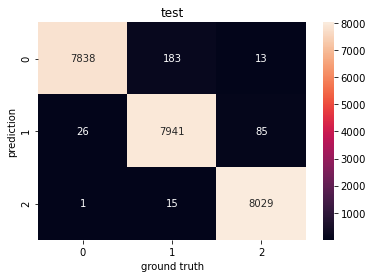

In [19]:
test_loader = DataLoader(train_set, batch_size=50, collate_fn=create_mini_batch)
%time x, y = model.test(test_loader)
print(classification_report(x, y, target_names=[str(i) for i in range(3)]))
draw_c_matrix(confusion_matrix(x, y))

Wall time: 7min 54s
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       778
           1       0.40      0.56      0.47       179
           2       0.94      0.92      0.93      1395

    accuracy                           0.86      2352
   macro avg       0.74      0.77      0.75      2352
weighted avg       0.88      0.86      0.87      2352



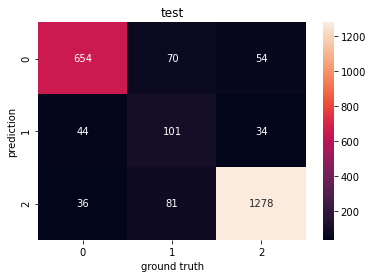

In [20]:
test_loader = DataLoader(amazon_20201210_test_set, batch_size=50, collate_fn=create_mini_batch)
%time x, y = model.test(test_loader)
print(classification_report(x, y, target_names=[str(i) for i in range(3)]))
draw_c_matrix(confusion_matrix(x, y))

Wall time: 35.9 s
              precision    recall  f1-score   support

           0       0.82      0.65      0.73       912
           1       0.31      0.45      0.36       389
           2       0.81      0.82      0.81       909

    accuracy                           0.68      2210
   macro avg       0.64      0.64      0.63      2210
weighted avg       0.72      0.68      0.70      2210



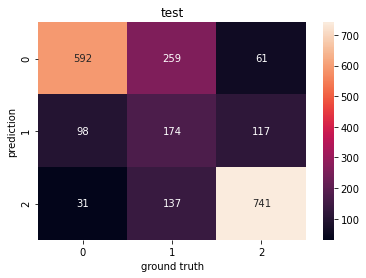

In [21]:
test_loader = DataLoader(sst5_test_set, batch_size=50, collate_fn=create_mini_batch, shuffle = True)
%time x, y = model.test(test_loader)
print(classification_report(x, y, target_names=[str(i) for i in range(3)]))
draw_c_matrix(confusion_matrix(x, y))

# predict

In [27]:
model.load_model('3-sst5-amazon-e-bert-base-cased.pkl')

In [28]:
model.predict("Not as extreme as touted", tokenizer) #3/5

(tensor([0], device='cuda:0'),
 tensor([[ 1.5225,  0.8453, -2.5618]], device='cuda:0'))

In [29]:
model.predict("IT WAS DIFFERENT TYPE MOVIE BUT IT WAS GOOD. SUSPENSEFUL.", tokenizer) #5/5

(tensor([2], device='cuda:0'),
 tensor([[-1.8068, -1.0228,  2.5835]], device='cuda:0'))

In [30]:
model.predict("Not impressed with this movie, too many unknown variables.", tokenizer) #1/5

(tensor([0], device='cuda:0'),
 tensor([[ 4.3638, -1.1546, -2.5655]], device='cuda:0'))

In [31]:
model.predict('The first half is outstanding. Lupita Nyongo is excellent as always -- shes a moody complex character which makes complete sense after the big reveal.Once that big reveal happens, suspending disbelief is difficult, even for a horror movie. It is almost as if they came up with the main premise, than spit-balled an explanation. The explanation / back story is so absurd it requires way too much exposition. Heres hoping Peele gets more grounded in his third act.', tokenizer) #3/5

(tensor([2], device='cuda:0'),
 tensor([[-2.0959, -0.4300,  1.9947]], device='cuda:0'))